In [32]:
# This works to make output cell wide, with a horiztonal scroll bar.
# https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [29]:
# change the cell width
# This doesn't scroll, just makes the cells wide.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
import xlwt, openpyxl

In [2]:
%cd /data/nijhawanlab/genewiz/
R1_file = "VK001_R1_001.fastq.gz"
R2_file = "VK001_R2_001.fastq.gz"
primer_file = "primers.txt"

/data/nijhawanlab/genewiz


In [3]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' # TTCTTGACGAGTTCTTCTGA
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' # ACGCGTCTGGAACAATCAAC
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'

In [4]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(primers_IO, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [5]:
forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [6]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [7]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [139]:
R1 = gzip.open(R1_file, "rt")
R2 = gzip.open(R2_file, "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
maxReads = 1000
readNumber = 0
reads_list = []
for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)
    
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    
    full_read = {}
    full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
    full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
    full_read.update({
        'R1_sequence':R1_sequence,
        'R2_sequence':R2_sequence
    })

    if(not None in full_read.values() ):       
        reads_list.append(full_read)
    # print(full_read)
    readNumber += 1
    if readNumber > maxReads:
        break

print(reads_list)
reads_table = pd.DataFrame(reads_list)
        
R1.close()
R2.close()

[{'R1_fwd_primer': 'oVK033', 'R1_fwd_primer_loc': 0, 'R1_rc_primer': 'oVK044', 'R1_rc_primer_loc': 159, 'R1_fwd_direction': 'F', 'R1_rc_direction': 'R', 'R2_fwd_primer': 'oVK044', 'R2_fwd_primer_loc': 0, 'R2_rc_primer': 'oVK033', 'R2_rc_primer_loc': 161, 'R2_fwd_direction': 'R', 'R2_rc_direction': 'F', 'R1_sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTGACTGTGTCTGAGTGACAGTCAGTACGCGTCTGGAACAATCAACCTCTGAACCACAAAA', 'R2_sequence': 'TTTTGTGGTTCAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCACTCAGACACAGTCACACTCAGAAGAACTCGTCAAGAAGGCGATAGAAGGCGATGCGCTGCGAATCGGGAGCGGCGATACCGTAAAGCACGAGGAAGCGGTCAGCCCATTCGCCGCCAAGCTCTTCAGCAATATCACGTTCAGC'}, {'R1_fwd_primer': 'oVK032', 'R1_fwd_primer_loc': 0, 'R1_rc_primer': 'oVK047', 'R1_rc_primer_loc': 155, 'R1_fwd_direction': 'F', 'R1_rc_direction': 'R', 'R2_fwd_primer': 'oVK047', 'R2_fwd_primer_loc': 0, 'R2_rc_primer': 'oVK032', 'R2_rc_primer_loc': 157, 'R2_fwd_direction': 'R', 

In [140]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,R2_fwd_direction,R2_rc_direction,R1_sequence,R2_sequence
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTGTGGTTCAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,R,F,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGGTAGACCAGAGGTTGATTGTTCCAGACGCGTTCTGAGTCACT...
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,F,R,TTTTGAGATACAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGTTAATCCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,R,F,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,F,R,TTTGTTAATCCAGAGGTTGATTGTTCCAGACTCGTTGACTCTCTCA...,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,F,R,TTTAGTCAGCCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,F,R,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCACACAGACT...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...


In [141]:
reads_table['sanity'] = (
    (reads_table['R1_fwd_primer'] == reads_table['R2_rc_primer']) &
    (reads_table['R1_rc_primer'] == reads_table['R2_fwd_primer']) &
    (reads_table['R1_fwd_direction'] == reads_table['R2_rc_direction']) &
    (reads_table['R1_rc_direction'] == reads_table['R2_fwd_direction']) &
    (reads_table['R1_fwd_direction'] != reads_table['R1_rc_direction']) 
)

In [142]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,R2_fwd_direction,R2_rc_direction,R1_sequence,R2_sequence,sanity
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTGTGGTTCAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,True
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,R,F,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGGTAGACCAGAGGTTGATTGTTCCAGACGCGTTCTGAGTCACT...,True
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,F,R,TTTTGAGATACAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGTTAATCCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,R,F,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,F,R,TTTGTTAATCCAGAGGTTGATTGTTCCAGACTCGTTGACTCTCTCA...,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,F,R,TTTAGTCAGCCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,F,R,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCACACAGACT...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True


In [143]:
reads_table['forward_primer']=reads_table['R1_fwd_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_rc_primer'])
reads_table['reverse_primer']=reads_table['R1_rc_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_fwd_primer'])
reads_table['sequence']=reads_table['R1_sequence'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R2_sequence'])

In [144]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,R2_fwd_direction,R2_rc_direction,R1_sequence,R2_sequence,sanity,forward_primer,reverse_primer,sequence
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTGTGGTTCAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,True,oVK033,oVK044,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,R,F,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGGTAGACCAGAGGTTGATTGTTCCAGACGCGTTCTGAGTCACT...,True,oVK032,oVK047,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,F,R,TTTTGAGATACAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK033,oVK040,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGTTAATCCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True,oVK033,oVK038,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,R,F,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,True,oVK031,oVK045,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,F,R,TTTGTTAATCCAGAGGTTGATTGTTCCAGACTCGTTGACTCTCTCA...,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK035,oVK038,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,F,R,TTTAGTCAGCCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK025,oVK042,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,R,F,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True,oVK033,oVK045,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,F,R,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCACACAGACT...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK032,oVK045,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...


In [145]:
pip install colored

Note: you may need to restart the kernel to use updated packages.


In [146]:
import colored
from colored import stylize
print(stylize("This is green.", colored.fg("green")))

This is green.


In [147]:
import colored
from colored import fg, bg, attr
from itertools import cycle

color_list = [39, 79, 160, 202, 124, 171, 245, 0]
default = bg('light_gray')

def ColorSeq(seq, intervals, offset=0):
    color = cycle(color_list)
    intervals.sort()
    if any(intervals[i+1][0]-intervals[i][1] <=0 for i in range(len(intervals)-1)):
        print("ColorSeq: Intervals cannot overlap.")
        return seq
    colored_string = default + offset*' ' # seq[:intervals[0][0]]
    last_index = 0 # intervals[0][1]
    for interval in intervals:
        colored_string += seq[last_index:interval[0]]
        c = next(color)
        colored_string += bg(c) + seq[interval[0]:interval[1]] + default
        last_index = interval[1]
    colored_string += seq[last_index:]
    return colored_string

In [148]:
seq='Never say never.'
s=ColorSeq(seq, [[2,5],[10,12]])
print(len(seq))
print(s)

16
Never say never.


In [149]:
print(ColorSeq(seq, [[0,2],[15,17]], offset=10
              ))

          Never say never.


In [150]:
primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

In [151]:
primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

In [152]:
def PrintSeq(n, table):
    read = table.iloc[n]
    highlights = ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
            [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'], read['R1_pre_loc'] + len(reference_sequence_pre) ],
            [read['R1_post_loc'], read['R1_post_loc'] + len(reference_sequence_post) ]
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'] + len(reference_sequence_pre), read['R1_post_loc']]
        ]
    )
    return highlights

In [160]:
h=PrintSeq(1, reads_table)
print(h)

GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGAGAGAGTGACAGTGACTCAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA
GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGAGAGAGTGACAGTGACTCAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA
GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGAGAGAGTGACAGTGACTCAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA


In [154]:
reads_table['R1_pre_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R1_post_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))

)
reads_table['R2_pre_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R2_post_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))
)

In [155]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_sequence,R2_sequence,sanity,forward_primer,reverse_primer,sequence,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTGTGGTTCAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,True,oVK033,oVK044,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,154,63,15
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGGTAGACCAGAGGTTGATTGTTCCAGACGCGTTCTGAGTCACT...,True,oVK032,oVK047,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,...,TTTTGAGATACAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCA...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK033,oVK040,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,63,15,106,154
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTGTTAATCCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True,oVK033,oVK038,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,...,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,True,oVK031,oVK045,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,149,58,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,...,TTTGTTAATCCAGAGGTTGATTGTTCCAGACTCGTTGACTCTCTCA...,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK035,oVK038,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,-1,106,-1
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,...,TTTAGTCAGCCAGAGGTTGATTGTTCCAGACGCGTACACTCTCACA...,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK025,oVK042,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,58,15,106,149
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCTCTCACAGT...,True,oVK033,oVK045,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,...,TTTTCTCTACCAGAGGTTGATTGTTCCAGACGCGTTCACACAGACT...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,True,oVK032,oVK045,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,15,106,150


In [156]:
reads_table['R1_barcode']=reads_table.apply(
    lambda row: row['R1_sequence'][row['R1_pre_loc']+len(reference_sequence_pre):row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: rcDNA( row['R1_sequence'][row['R1_post_loc']+len(reference_sequence_post):row['R1_pre_loc']] ), axis=1)
)

reads_table['R2_barcode']=reads_table.apply(
    lambda row: row['R2_sequence'][row['R2_pre_loc']+len(reference_sequence_pre):row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: rcDNA( row['R2_sequence'][row['R2_post_loc']+len(reference_sequence_post):row['R2_pre_loc']] ), axis=1)
)

In [157]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,sanity,forward_primer,reverse_primer,sequence,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode,R2_barcode
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,...,True,oVK033,oVK044,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,154,63,15,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTGTGACTGTGTCTGAGTGACAGTCAGT
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,...,True,oVK032,oVK047,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,GAGAGAGAGTGACAGTGACTCAGA,GAGAGAGAGTGACAGTGACTCAGA
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,...,True,oVK033,oVK040,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,63,15,106,154,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTGTGACTGTGTCTGAGTGACAGTCAGT
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,...,True,oVK033,oVK038,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,CACTGTCTGTCAGACTGTGAGAGA,CACTGTCTGTCAGACTGTGAGAGA
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,...,True,oVK031,oVK045,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,149,58,15,GAGAGTGTAGTGTGTGAGAGTGT,GAGAGTGTAGTGTGTGAGAGTGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,...,True,oVK035,oVK038,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,-1,106,-1,GTGAGAGTGAGAGTGAGAGAGTCAACGAGTCTGGAACAAT,GTGAGAGTGAGAGTGAGAGAGTCAACGAGTCTGGAACAATCAACCT...
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,...,True,oVK025,oVK042,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,58,15,106,149,GAGAGTGTAGTGTGTGAGAGTGT,GAGAGTGTAGTGTGTGAGAGTGT
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,...,True,oVK033,oVK045,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,CACTGTCTGTCAGACTGTGAGAGA,CACTGTCTGTCAGACTGTGAGAGA
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,...,True,oVK032,oVK045,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,15,106,150,CTGTGTGTGTCTGAGTCTGTGTGA,CTGTGTGTGTCTGAGTCTGTGTGA


In [158]:
barcode_regex = re.compile('([GC][AT])+')

def CheckBarcodePattern(b):
    if barcode_regex.fullmatch(b):
        return True
    else:
        return False

reads_table['barcode_sanity']=reads_table['R1_barcode'].apply( CheckBarcodePattern )

reads_table['barcodes_match']=(
    (reads_table['R1_barcode']==reads_table['R2_barcode'])
)

reads_table['barcode_length']=reads_table['R1_barcode'].apply( len )

In [159]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,sequence,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode,R2_barcode,barcode_sanity,barcodes_match,barcode_length
0,oVK033,0,oVK044,159,F,R,oVK044,0,oVK033,161,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,154,63,15,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,True,28
1,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,GAGAGAGAGTGACAGTGACTCAGA,GAGAGAGAGTGACAGTGACTCAGA,True,True,24
2,oVK040,0,oVK033,161,R,F,oVK033,0,oVK040,159,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,63,15,106,154,GTGTGACTGTGTCTGAGTGACAGTCAGT,GTGTGACTGTGTCTGAGTGACAGTCAGT,True,True,28
3,oVK033,0,oVK038,155,F,R,oVK038,0,oVK033,157,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,CACTGTCTGTCAGACTGTGAGAGA,CACTGTCTGTCAGACTGTGAGAGA,True,True,24
4,oVK031,0,oVK045,154,F,R,oVK045,0,oVK031,156,...,GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,149,58,15,GAGAGTGTAGTGTGTGAGAGTGT,GAGAGTGTAGTGTGTGAGAGTGT,False,True,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,oVK038,0,oVK035,157,R,F,oVK035,0,oVK038,155,...,GCCTCCGGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,-1,106,-1,GTGAGAGTGAGAGTGAGAGAGTCAACGAGTCTGGAACAAT,GTGAGAGTGAGAGTGAGAGAGTCAACGAGTCTGGAACAATCAACCT...,False,False,40
608,oVK042,0,oVK025,156,R,F,oVK025,0,oVK042,154,...,GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,58,15,106,149,GAGAGTGTAGTGTGTGAGAGTGT,GAGAGTGTAGTGTGTGAGAGTGT,False,True,23
609,oVK033,0,oVK045,155,F,R,oVK045,0,oVK033,157,...,GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,106,150,59,15,CACTGTCTGTCAGACTGTGAGAGA,CACTGTCTGTCAGACTGTGAGAGA,True,True,24
610,oVK045,0,oVK032,157,R,F,oVK032,0,oVK045,155,...,GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACC...,59,15,106,150,CTGTGTGTGTCTGAGTCTGTGTGA,CTGTGTGTGTCTGAGTCTGTGTGA,True,True,24


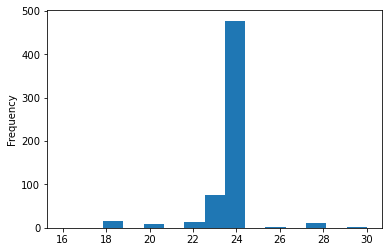

In [166]:
reads_table['barcode_length'].plot.hist(range=(16,30), bins=15)

In [224]:
from colored import bg, fg, attr
from itertools import chain

def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

def InsertCodes(s, code_tuples, default_code=bg(231)+fg(0)):
    code_tuples.sort()
    indices = [0] + [i[0] for i in code_tuples] + [len(s)]
    codes = [i[1] for i in code_tuples] + [default_code]
    substrings = SplitString(s, indices)
    return default_code + ''.join( chain(*zip(substrings,codes)) )

def DisplayRow(row):
    display_string = row['R1_sequence']
    default_fg = fg('black')
    default_bg = bg('grey_100')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (row['R1_fwd_primer_loc'], bg('light_gray')),
        (row['R1_fwd_primer_loc']+primer_lookup[ row['R1_fwd_primer'] ]['len'], default_bg),
        # reverse primer
        (row['R1_rc_primer_loc'], bg('light_gray')),
        (row['R1_rc_primer_loc']+primer_lookup[ row['R1_rc_primer'] ]['len'], default_bg),
        # pre-flanking sequence
        (row['R1_pre_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (row['R1_post_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if row['R1_fwd_direction']=='F':
        # barcode
        color_codes += [
            (row['R1_pre_loc']+len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (row['R1_post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (row['R1_post_loc']+len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (row['R1_pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# following not done: need to take out the R1 and pass in 'fwd_primer_loc', etc
def DisplaySeq(seq, locations):
    display_string = seq
    default_fg = fg('black')
    default_bg = bg('grey_100')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (locations['fwd_primer_loc'], bg('light_gray')),
        (locations['fwd_primer_loc'] + locations['fwd_primer_len'], default_bg),
        # reverse primer
        (locations['rc_primer_loc'], bg('light_gray')),
        (locations['rc_primer_loc'] + locations['rc_primer_len'], default_bg),
        # pre-flanking sequence
        (locations['pre_loc'], attr('bold')+fg('navy_blue')),
        (locations['pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (locations['post_loc'], attr('bold')+fg('navy_blue')),
        (locations['post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if locations['direction']=='F':
        # barcode
        color_codes += [
            (locations['pre_loc'] + len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (locations['post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (locations['post_loc'] + len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (locations['pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# Need to reverse the direction for 'R' reads
def DisplayRowWithDirection(row, read):
    # row is a row of reads_table
    # read = 1 or 2
    if read == 1:
        readchar = 'R1'
    else:
        readchar = 'R2'
    if row[readchar + '_fwd_direction'] == 'F':
        direction = 'F'
        seq = row[readchar + '_sequence']
        postrx = lambda x: x
    else:
        direction = 'R'
        seq = row[readchar + '_sequence'][::-1]
        l = len(seq)
        postrx = lambda x: l - 1 - x # not working
    
    locations = {
        'fwd_primer_loc':postrx( row[readchar + '_fwd_primer_loc'] ),
        'fwd_primer_len':primer_lookup[ row[readchar + '_fwd_primer'] ]['len'],
        'rc_primer_loc':postrx( row[readchar + '_rc_primer_loc'] ),
        'rc_primer_len':primer_lookup[ row[readchar + '_rc_primer'] ]['len'],
        'pre_loc':postrx( row[readchar + '_pre_loc'] ),
        'post_loc':postrx( row[readchar + '_post_loc'] ),
        'fwd_primer':row[readchar + '_fwd_primer'],
        'rc_primer':row[readchar + '_rc_primer']
    }
    locations['direction']=direction,
    
    return DisplaySeq(seq, locations)

In [217]:
print(
    DisplayRow( reads_table.iloc[1] )
)
print(
    DisplayRow( reads_table.iloc[2] )
)
print(
    DisplayRow( reads_table.iloc[3] )
)

GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGAGAGAGTGACAGTGACTCAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA
TTTTGAGATACAGAGGTTGATTGTTCCAGACGCGTACTGACTGTCACTCAGACACAGTCACACTCAGAAGAACTCGTCAAGAAGGCGATAGAAGGCGATGCGCTGCGAATCGGGAGCGGCGATACCGTAAAGCACGAGGAAGCGGTCAGCCCATTCGCCGCCAAGCTCTTCAGCAATATCACGTTCAGC
GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGACACTGTCTGTCAGACTGTGAGAGAACGCGTCTGGAACAATCAACCTCTGGATTAACAAA


In [225]:
print(
    DisplayRowWithDirection( reads_table.iloc[1], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[1], 2 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 2 )
)

GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGAGAGAGAGTGACAGTGACTCAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA
CGATGACGACTATAACGACTTCTCGAACCGCCGCTTACCCGACTGGCGAAGGAGCACGAAATGCCATAGCGGCGAGGGCTAAGCGTCGCGTAGCGGAAGATAGCGGAAGAACTGCTCAAGAAGACTCTCTCTCTCACTGTCACTGAGTCTTGCGCAGACCTTGTTAGTTGGAGACCAGATGGTTT
CGACTTGCACTATAACGACTTCTCGAACCGCCGCTTACCCGACTGGCGAAGGAGCACGAAATGCCATAGCGGCGAGGGCTAAGCGTCGCGTAGCGGAAGATAGCGGAAGAACTGCTCAAGAAGACTCACACTGACACAGACTCACTGTCAGTCATGCGCAGACCTTGTTAGTTGGAGACATAGAGTTTT
GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTGACTGTGTCTGAGTGACAGTCAGTACGCGTCTGGAACAATCAACCTCTGTATCTCAAAA
